# 3. Loading and fitting multiple diffraction patterns

A key use for XRD is monitoring the change in the structure of a material over time. If a number of diffraction patterns are collected over time `xrdfit` can be used to automatically fit the peaks and extract the changing fit parameters over time. The change in the positions or heights of the peaks can then be correlated to material properties. We call the fitting of multiple **spectra** an **Experiment**.

In the example files folder there is a sequence of 10 diffraction patterns which we will use for demonstration. The workflow used in `xrdfit` assumes that the data are stored in sequentially numbered files, one spectrum per file, all in the same folder.

## 3.1. Fitting a peak at multiple times

The idea behind the time fitting in `xrdfit` is that you should be able to set up the peaks to fit in for the first timestep of the experiment and then run the fits automatically for the rest of the timesteps without manual intervention. The code will follow the changing positions of the peaks over time.

In order to fit peaks they must exist in the first frame of the fitting experiment. If peaks appear part way through an experiment then the spectrum will have to be fitted in parts, the appearing peaks being fitted only after they appear. As long as a peak exists at the start of the experiment, `xrdfit` should be able to cope with a peak disappearing for a time and reappearing later (an example is shown in tutorial notebook 4). If peaks merge together over time the behavior of `xrdfit` is not defined. In this case the fitting may need more manual adjustment.

The first step in setting up a multi-time fit is to load an `FitExperiment` object - this contains some metadata about the experiment and will hold one `FitSpectrum` for each diffraction pattern. The *first_cake_angle*, *cakes_to_fit*, *peak_params* and *merge_cakes* parameters are the same as previously defined. The *spectrum_time* parameter sets the number of seconds between each spectrum in the sequence - this value is used to appropriately label the time on the x-axis of plots. The *file_stub* parameter is used to locate the files for analysis. To use all of the spectra in a folder that are sequentially numbered - provide the stub of the file name with a star (wildcard).

Once the `FitExperiment` object is loaded, the `run_analysis` method runs the fit over all of the specified files.

In [1]:
%matplotlib inline

import xrdfit.spectrum_fitting as spectrum_fitting
from xrdfit.spectrum_fitting import PeakParams

first_cake_angle = 90
cakes_to_fit = [36, 1, 2]
peak_params = PeakParams('1', (2.75, 2.95))
merge_cakes = True

spectrum_time = 1
file_stub = "../example_data/adc_041_7Nb_NDload_700C_15mms_*"

experiment = spectrum_fitting.FitExperiment(spectrum_time, file_stub, first_cake_angle, 
                                            cakes_to_fit, peak_params, merge_cakes)

experiment.run_analysis()

Processing 10 diffraction patterns.



Analysis complete.


The results are hierarchically stored in the `FitExperiment` object and can be accessed directly if you wish. 

However, it is probably easier to use the `FitExperiment` helper methods described below to plot the results rather than accessing the raw fit data directly.

The `peak_names` method lists the names of the fitted peaks specified in the `PeakParams` objects. The `fit_parameters` method gives a list of the names of the fit parameters for a particular peak.

In [2]:
print(experiment.peak_names())
print(experiment.fit_parameters('1'))

['1']
['maximum_1_amplitude', 'maximum_1_center', 'maximum_1_sigma', 'maximum_1_fraction', 'maximum_1_fwhm', 'maximum_1_height', 'maximum_1_snr', 'background']


To plot a parameter for a fit over time use the `plot_fit_parameter` method. To plot all of the parameters for all of the peaks use a loop:

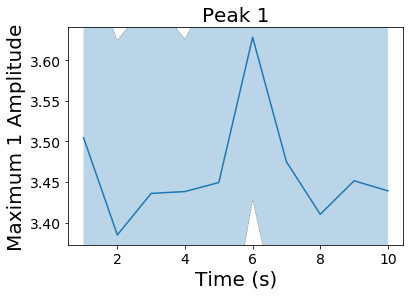

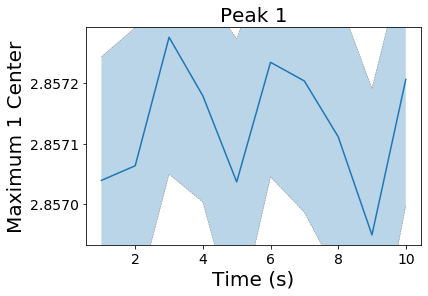

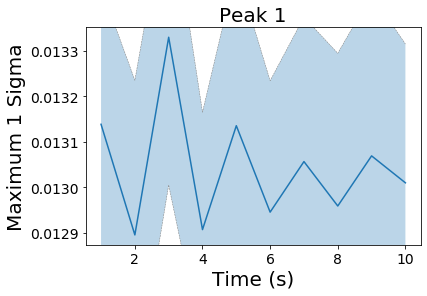

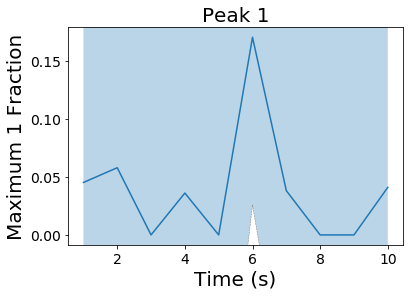

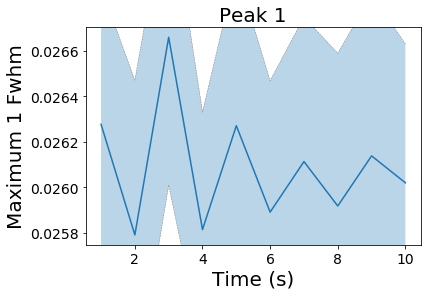

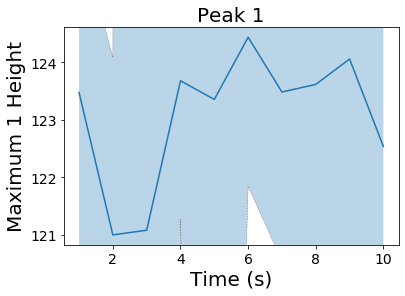

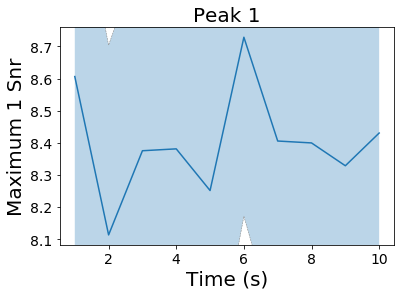

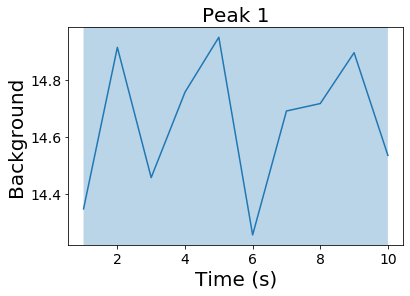

In [3]:
for peak_name in experiment.peak_names():
    for parameter in experiment.fit_parameters(peak_name):
        experiment.plot_fit_parameter(peak_name, parameter)

The blue line is the value of the parameter while the light blue shaded area is +- 1 standard error on the determination of the parameter from the fit. By default, the plots scale the y-axis to the data, not the error bars but the y-scale can be adjusted with the *scale_by_error* parameter:

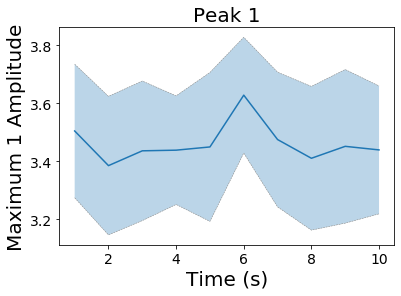

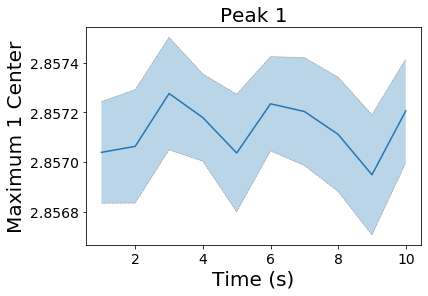

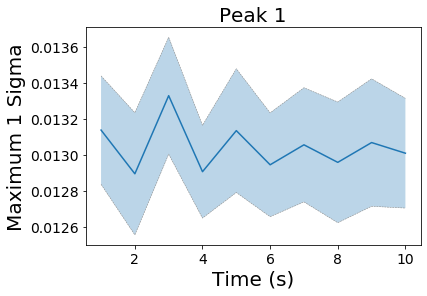

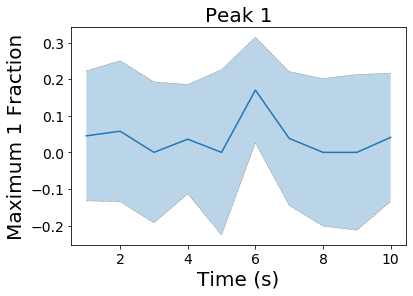

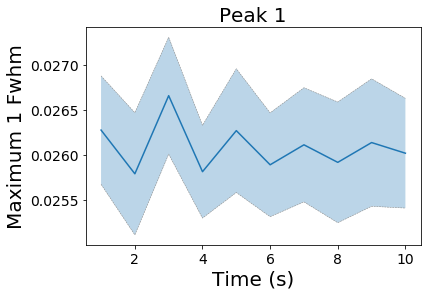

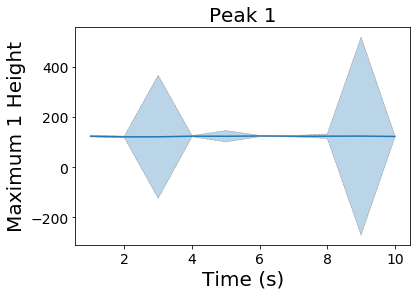

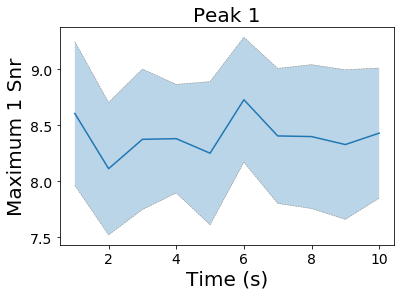

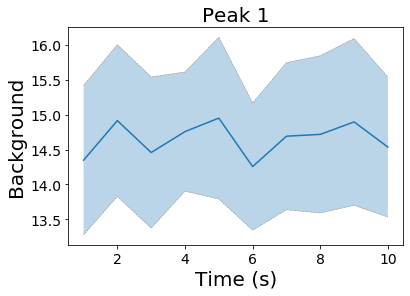

In [4]:
for peak_name in experiment.peak_names():
    for parameter in experiment.fit_parameters(peak_name):
        experiment.plot_fit_parameter(peak_name, parameter, scale_by_error=True)

In this case the errors on the parameters are small indicating a good fit, however fit parameters do not change significantly either. This is because the 10 example files represent only a short time period where little was changing in the material.

Error bars are plotted by default, to turn them off you can use the `show_error` parameter:

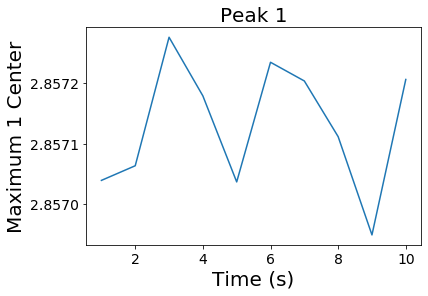

In [5]:
experiment.plot_fit_parameter("1", "maximum_1_center", show_error=False)

## 3.2. Fitting multiple peaks at multiple times
We can set up a larger analysis to fit multiple peaks over time. It is probably a good workflow to determine good values for the `PeakParams` on a single spectrum first using a `FitSpectrum` object, to check that the fits are good and then use them to run over multiple files using a `FitExperiment`. Here we take the `PeakParams` determined in the first tutorial notebooks.

In [6]:
first_cake_angle = 90
cakes_to_fit = [36, 1, 2]


peak_params = [PeakParams('1', (2.75, 2.95)),
               PeakParams('Triplet',  (3.02, 3.32), [(3.09, 3.12), (3.19, 3.22), (3.24, 3.26)]),
               PeakParams('4', (4.13, 4.30))]

merge_cakes = True

spectrum_time = 1
file_stub = "../example_data/adc_041_7Nb_NDload_700C_15mms_*"

experiment = spectrum_fitting.FitExperiment(spectrum_time, file_stub, first_cake_angle, 
                                            cakes_to_fit, peak_params, merge_cakes)

experiment.run_analysis()

Processing 10 diffraction patterns.



Analysis complete.


Lets see what parameters we can now plot using the `FitExpreiment.peak_names` and `FitExperiment.fitParameters` methods:

In [7]:
print(experiment.peak_names(), "\n")
for peak_name in experiment.peak_names():
    print(experiment.fit_parameters(peak_name), "\n")

['1', 'Triplet', '4'] 

['maximum_1_amplitude', 'maximum_1_center', 'maximum_1_sigma', 'maximum_1_fraction', 'maximum_1_fwhm', 'maximum_1_height', 'maximum_1_snr', 'background'] 

['maximum_1_amplitude', 'maximum_1_center', 'maximum_1_sigma', 'maximum_1_fraction', 'maximum_2_amplitude', 'maximum_2_center', 'maximum_2_sigma', 'maximum_2_fraction', 'maximum_3_amplitude', 'maximum_3_center', 'maximum_3_sigma', 'maximum_3_fraction', 'maximum_1_fwhm', 'maximum_1_height', 'maximum_1_snr', 'maximum_2_fwhm', 'maximum_2_height', 'maximum_2_snr', 'maximum_3_fwhm', 'maximum_3_height', 'maximum_3_snr', 'background'] 

['maximum_1_amplitude', 'maximum_1_center', 'maximum_1_sigma', 'maximum_1_fraction', 'maximum_1_fwhm', 'maximum_1_height', 'maximum_1_snr', 'background'] 



Here we can see that we have the three peaks we have fitted. Notice that the second peak has three sets of fit parameters. Since the third peak is fitted with a compound triplet fit, the parameters prefixed with "maximum_1_" corresponds to the first maxima and 'maximum_2" the second maxima etc.

We likely want to focus on a subset of the parameters rather than plotting them all. This time we use a Python `if` statement to select only the parameters corresponding to the peak centers.

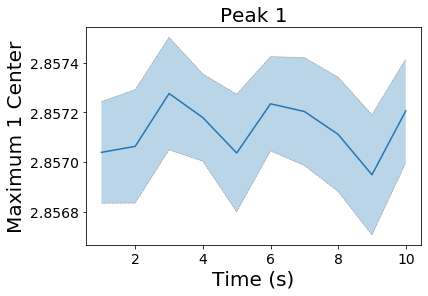

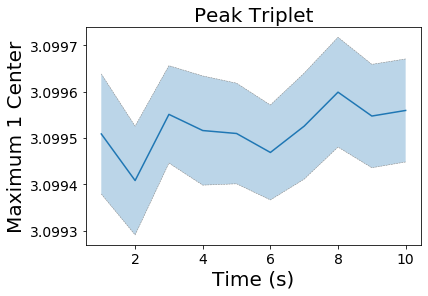

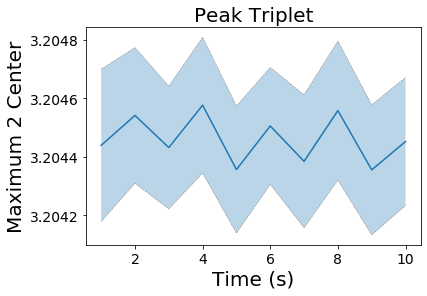

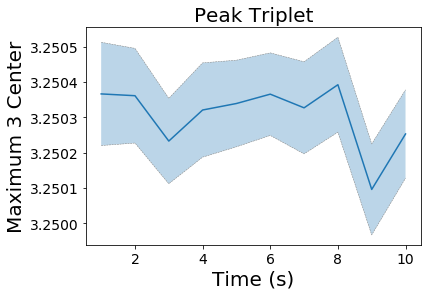

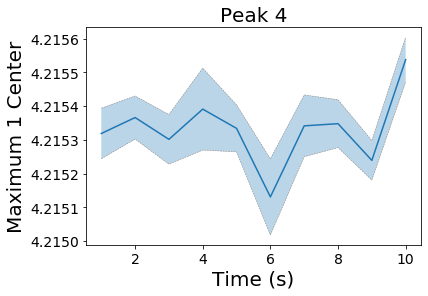

In [8]:
for peak_name in experiment.peak_names():
    for parameter in experiment.fit_parameters(peak_name):
        if "center" in parameter:
            experiment.plot_fit_parameter(peak_name, parameter, scale_by_error=True)

## 3.3. Plotting fits

It is good practice to check the fits directly (or at least a subset of them) to check that the automated fits are working correctly. To get an idea of how the fits went you can plot the fits from a time series using the `plot_fits` method. By default the method prints plots for 5 timesteps, evenly spaced in time, plotting one plot for each fitted peak.

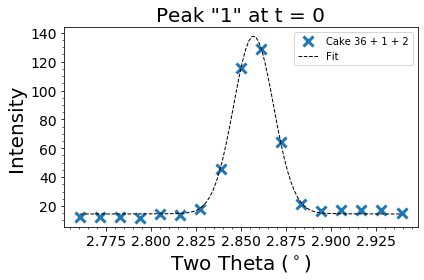

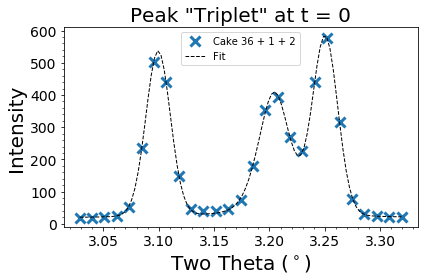

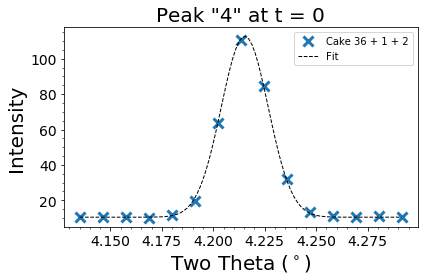

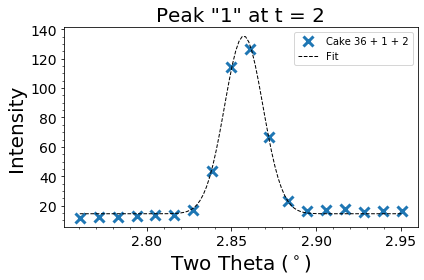

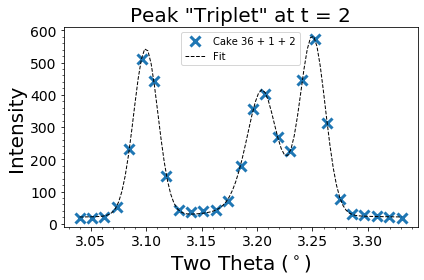

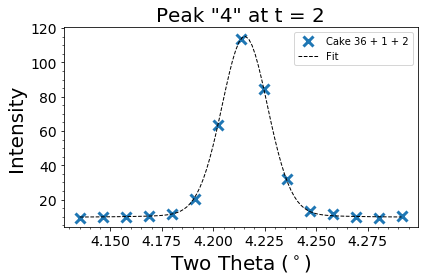

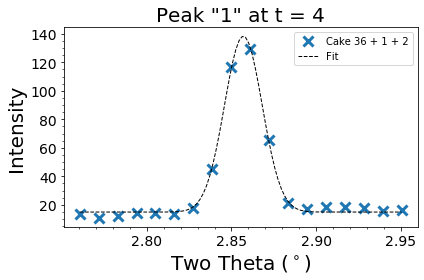

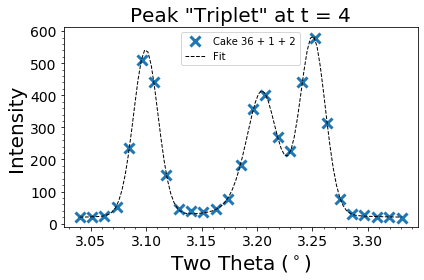

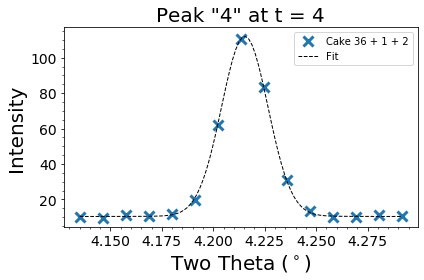

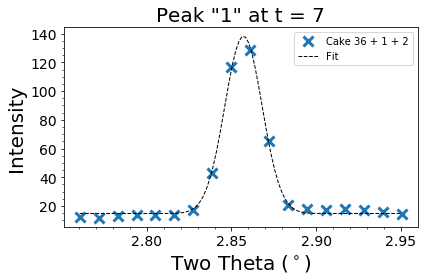

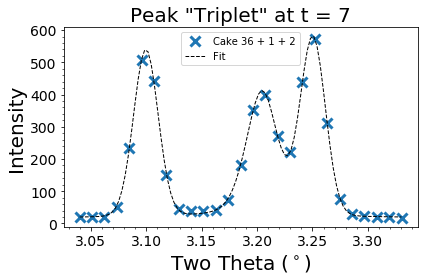

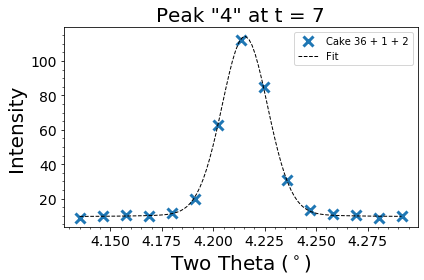

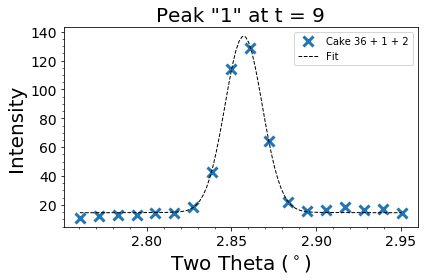

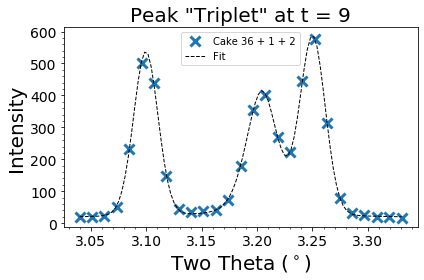

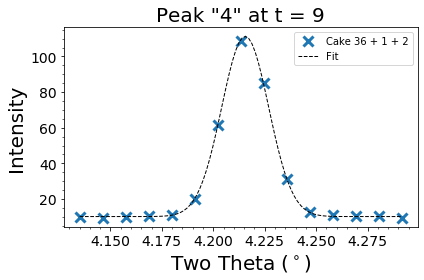

In [9]:
experiment.plot_fits()

This could potentially be a lot of plots so you can narrow down the plots you want by providing different arguments to the plot_fits function. `num_timesteps` sets how many evenly spaced timesteps to plot (default: 5). `peak_names` is a list of one or more peak names to plot (default: all fitted peaks). `timesteps` is a list of integer values specifying which timesteps to plot, if timesteps is provided then `num_timesteps` will be ignored.

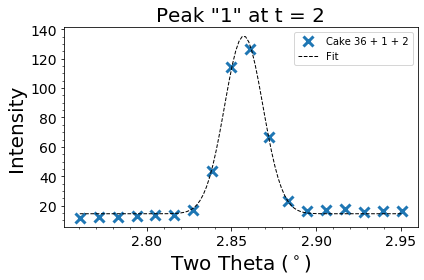

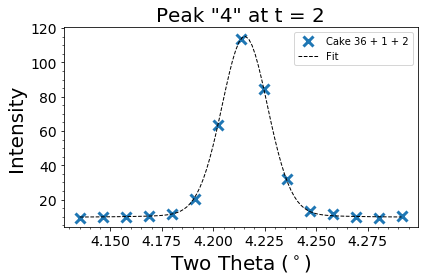

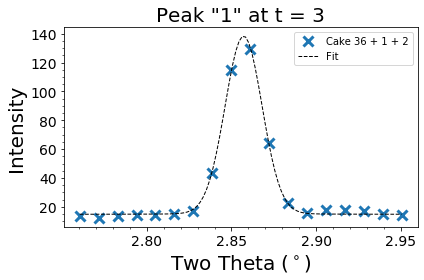

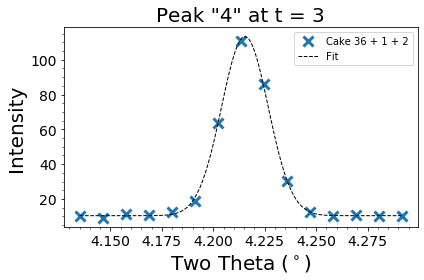

In [10]:
experiment.plot_fits(peak_names=["1", "4"], timesteps=[2, 3])

## 3.4. Fitting a subset of timesteps

Sometimes it is the case that we do not want to process all spectra in a series. Perhaps the sampling frequency is too high and we only want to fit every other spectrum or every 10th spectrum. Perhaps the interesting data is at the end so you want to skip fitting the first 100 spectra. This can be done by supplying an extra parameter to the `FitExperiment` object.

The *frames_to_load* parameter is a list of integer values specifying which files to load. The file stub also has to be modified here - adding a python format string where the numbers need to be substituted in the file name. In this example `:05d` corresponds to a 5 digit wide integer padded with zeros. This means 1 will become 00001, 10 will become 00010 etc. For more on python sting formatting see here: https://pyformat.info/#number

The below example will be just the same as the one above except it will only load spectra 1, 3 and 4 from the example folder. Notice how the x-axis on the parameter plots scales correctly - leaving a gap at 2 seconds where there is no data.

Processing 3 diffraction patterns.



Analysis complete.


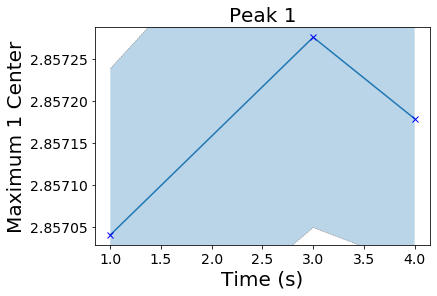

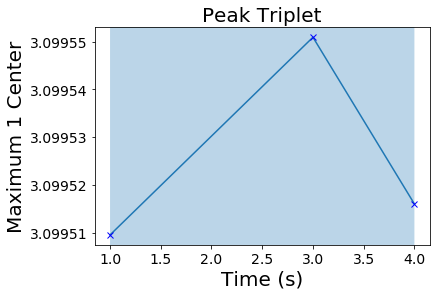

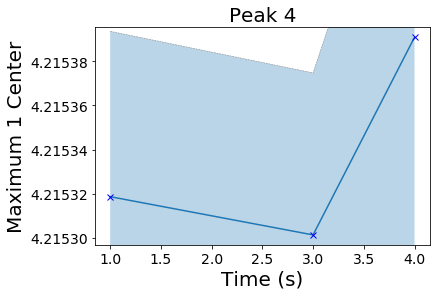

In [11]:
frames_to_load = [1, 3, 4]
file_stub = "../example_data/adc_041_7Nb_NDload_700C_15mms_{:05d}.dat"

experiment = spectrum_fitting.FitExperiment(spectrum_time, file_stub, first_cake_angle, 
                                            cakes_to_fit, peak_params, merge_cakes, frames_to_load)

experiment.run_analysis()
for peak_name in experiment.peak_names():
    experiment.plot_fit_parameter(peak_name, "maximum_1_center", show_points=True)

To get the raw data you can use the `get_fit_parameter` method. The first column is the time (x-data), the second column is the requested parameter (y-data) and the third column is the standard error on the fit parameter (y-error) estimated from the fitting covariance matrix.

In [12]:
experiment.get_fit_parameter("1", "maximum_1_center")

array([[1.00000000e+00, 2.85704039e+00, 1.98114750e-04],
       [3.00000000e+00, 2.85727608e+00, 2.26832349e-04],
       [4.00000000e+00, 2.85717889e+00, 1.75971668e-04]])

Once you have done an experiment it may be desirable to save the fits to be able to refer back to them later.

This can be done using the `save` method of the `FitExperiment` object.

In [13]:
experiment.save("experiment.dump")

Saving data to dump file.
Data successfully saved to dump file.


This file is a compressed binary file and so is not human readable. Note that although the file is compressed, the output may well be large - typically on the order of the size of the input data since the input data is embedded in the object.

To read in a previously saved `FitExperiment` object, use the `spectrum_fitting.load_dump` method. This returns a new `FitExperiment` with the saved fits which you can operate on just as before.

Loading data from dump file.
Data successfully loaded from dump file.


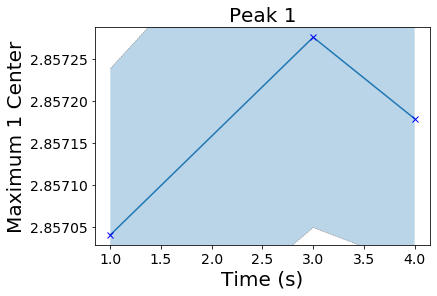

In [14]:
old_experiment = spectrum_fitting.load_dump("experiment.dump")
experiment.plot_fit_parameter("1", "maximum_1_center", show_points=True)

## 3.5. Using previous fits as a starting point for the next fit

It is possible to use the result of a fit from a previous time step as the starting parameters for the next fit. You can do this by using the reuse_fits parameter of the `run_analysis` method. 

In [15]:
experiment.run_analysis(reuse_fits=True)

Processing 3 diffraction patterns.



Analysis complete.


Reusing the fits can provide a significant speedup in fitting, especially if the fits change little between timesteps as in this case the previous fit should be a good starting point for the next one. 

If the fits are quite different between timesteps it is likely better to not reuse the fits. In this case the code will make an educated guess about the parameters at each timestep instead.

We have previously found that while reusing fits often improves performance, on occasion reusing the fits can cause poor fitting performance, taking many iterations to complete each fit. Try with and without reusing fits and see which works best for your dataset.